In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math

import openai

In [ ]:
#gpt enough tokens
#https://platform.openai.com/docs/models/gpt-3-5-turbo
#https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them

In [2]:
# pip install openai==0.28

In [2]:
openai.__version__

'0.28.0'

In [3]:
#Open AI set up

#4,oMWXRSsSu58dYT6KbF4R,50000000,Public Opinion
openai.api_base="http://91.107.239.71:80"
api_key = "oMWXRSsSu58dYT6KbF4R"
openai.api_key = api_key

In [4]:
anes = pd.read_csv('anes_timeseries_2020_csv_20220210.csv')

# Question had an option for free text answer, which is not useful for the analysis
# turned into negative value to not take it into account
anes['V201336'].replace(5, -7, inplace=True)

C:\Users\agust\AppData\Local\Temp\ipykernel_23824\66338664.py:1: DtypeWarning: Columns (15,17,18,19,21,22,23,25,26,27,29,30,31,33,34,35,37,38,1508,1509) have mixed types. Specify dtype option on import or set low_memory=False.
  anes = pd.read_csv('anes_timeseries_2020_csv_20220210.csv')


In [5]:
questcode_topic = {"V201336": "abortion1",
              "V201342x": "abortion2",
              "V202332": "climate change1",
              "V202333": "climate change2",
              "V202337": "gun control1",
              "V202341x": "gun control2",
              "V202344x": "gun control3",
              "V202232": "immigration1",
              "V202233": "immigration2",
              "V202236x":"immigration3",
              "V202380x": "public health1"}


In [6]:
# Questions
questions = {
# Abortion 1:
"V201336":
"""There has been some discussion about abortion during recent
years. Which one of the opinions on this page best agrees with
your view?
1. By law, abortion should never be permitted
2. The law should permit abortion only in case of rape, incest, or
when the woman\'s life is in danger
3. The law should permit abortion other than for
rape/incest/danger to woman but only after need clearly
established
4. By law, a woman should always be able to obtain an abortion
as a matter of personal choice"""
# Put "You can just tell me the number of the opinion you choose." away not to mix the LLMs


# Abortion 2:
, "V201342x":
"""Would you be pleased, upset, or neither pleased nor upset if the
Supreme Court reduced abortion rights?
1. Extremely pleased
2. Moderately pleased
3. A little pleased
4. Neither pleased nor upset
5. A little upset
6. Moderately upset
7. Extremely upset"""


# Climate change 1:
, "V202332":
"""How much, if at all, do you think climate change is currently
affecting severe weather events or temperature patterns in the
United States?
1. Not at all
2. A little
3. A moderate amount
4. A lot
5. A great deal"""

# Climate change 2:
, "V202333":
"""How important is the issue of climate change to you personally?
1. Not at all important
2. A little important
3. Moderately important
4. Very important
5. Extremely important"""


# Gun control 1:
, "V202337":
"""Do you think the federal government should make it more
difficult for people to buy a gun than it is now, make it easier for
people to buy a gun, or keep these rules about the same as they
are now?
1. More difficult
2. Easier
3. Keep these rules about the same"""

# Gun control 2:
, "V202341x":
"""Do you favor, oppose, or neither favor nor oppose requiring
background checks for gun purchases at gun shows or other
private sales?
1. Favor a great deal
2. Favor a moderate amount
3. Favor a little
4. Neither favor nor oppose
5. Oppose a little
6. Oppose a moderate amount
7. Oppose a great deal"""

# Gun control 3:
, "V202344x":
"""Do you favor, oppose, or neither favor nor oppose banning the
sale of semi-automatic “assault-style” rifles?
1. Favor a great deal
2. Favor a moderate amount
3. Favor a little
4. Neither favor nor oppose
5. Oppose a little
6. Oppose a moderate amount
7. Oppose a great deal"""

# Immigration 1:
, "V202232":
"""Do you think the number of immigrants from foreign countries
who are permitted to come to the United States to live should be
increased a lot, increased a little, left the same as it is now,
decreased a little, or decreased a lot?
1. Increased a lot
2. Increased a little
3. Left the same as it is now
4. Decreased a little
5. Decreased a lot"""

# Immigration 2:
, "V202233":
"""Now I’d like to ask you about immigration in recent years.
How likely is it that recent immigration levels will take jobs away
from people already here – extremely likely, very likely,
somewhat likely, or not at all likely?
1. Extremely likely
2. Very likely
3. Somewhat likely
4. Not at all likely"""

# Immigration 3:
, "V202236x":
"""Do you favor, oppose, or neither favor nor oppose allowing
refugees who are fleeing war, persecution, or natural disasters
in other countries to come to live in the U.S.?
1. Favor a great deal
2. Favor a moderate amount
3. Favor a little
4. Neither favor nor oppose
5. Oppose a little
6. Oppose a moderate amount
7. Oppose a great deal"""

# Public Health 1:
, "V202380x":
"""Do you favor an increase, decrease, or no change in
government spending tohelp people pay for health insurance
when they can’t pay for it all themselves?
1. Increase a great deal
2. Increase a moderate amount
3. Increase a little
4. No change
5. Decrease a little
6. Decrease a moderate amount
7. Decrease a great deal"""
}

In [7]:
mean_var = {}

for key, value in questions.items():
    # Only include valid answers
    valid = anes[anes[key] > 0]
    # frequencies = valid[key].value_counts()
    column_mean = valid[key].mean()
    column_var = valid[key].var()
    num_respondents = len(valid[key])
    mean_var[key] = [column_mean, column_var, num_respondents]
    
mean_var

{'V201336': [3.0456962025316456, 1.189581424343106, 7900],
 'V201342x': [4.689327485380117, 4.338709039566053, 8208],
 'V202332': [3.5717382468500203, 1.8473258263269425, 7381],
 'V202333': [3.340511986997156, 1.825786082997807, 7383],
 'V202337': [1.89735593220339, 0.9236911365172453, 7375],
 'V202341x': [1.6703668607012319, 1.812394165422136, 7387],
 'V202344x': [3.207424468229237, 5.664150831861712, 7381],
 'V202232': [2.9915646258503403, 1.2937103016468015, 7350],
 'V202233': [3.0364054675869534, 0.8464005047669663, 7389],
 'V202236x': [3.072867378667027, 3.1129968202944625, 7397],
 'V202380x': [3.0557224801966676, 2.7443334555495578, 7322]}

In [1]:
# #All histograms

# for key, values in mean_var.items():
#     issue = questcode_topic[key]
#     valid_ans = anes[anes[key] > 0]
    
#     # Calculate number of unique answers
#     num_answers = len(valid_ans[key].unique())
   
#     labels, counts = np.unique(valid_ans[key].to_numpy(), return_counts=True)
#     plt.bar(labels, counts, align='center')
#     plt.gca().set_xticks(labels)
#     for label, count in zip(labels, counts):
#         plt.text(label, count, str(count), ha='center', va='bottom')

#     plt.title('Histogram of {}'.format(issue))
#     plt.xlabel('Values')
#     plt.ylabel('Frequency')
    
#     plt.show()

In [9]:
# Prompt2
# def prompt(question, num_respondents):
#     prompt_text = 'In the following you will be given a question followed several possible answer categories. Please \
#     estimate how a representative sample of %d US-Americans would have answered the question in 2020 by providing a \
#     frequency table that shows answer frequency of each answer option (output a dictionary object with answer category \
#     number as key and answer frequency as value). Please make sure that the sum of the answers you provide matches\
#      %d. Here is the questions: %s'%(num_respondents, num_respondents, question)
    
#     return prompt_text

In [8]:
# Percentage prompt
def prompt_zero(question, num_respondents):
    prompt_text = 'In the following you will be given a question followed several possible answer categories. Please \
    estimate how a representative sample of %d US-Americans would have answered the question in 2020 by providing the\
    number of respondents for each answer option in percent (output a dictionary object with answer category number as\
    key and answer frequency in percent as value. Only provide the number without the percentage sign).\
    Here is the questions: %s'%(num_respondents, question)
    
    return prompt_text

In [38]:
runs = 2

openai_ans = {}
for question in questions: #"questions" object has all questions 
    
    #original survey valid answers
    valid_ans = anes[anes[question] > 0]
    survey_ans = len(valid_ans)

    #prompt for question (question + total answers)
    prompt_text = prompt_zero(questions[question], survey_ans)

    #answer generation
    responses = openai.ChatCompletion.create(model="gpt-3.5-turbo-0125", 
                                            messages=[{"role": "user", "content": prompt_text}],
                                            n = runs
                                            )

    final_ans = [i['message']['content'] for i in responses['choices']]
    final_ans_dict = [eval(i) for i in final_ans]
    #also include in the final object the info on the total number of respondents
    final_ans_dict.append(survey_ans)
    openai_ans[question] = final_ans_dict
    

In [31]:
# filename = "openai_zero_results.json"
# with open(filename, "w") as f:
#     json.dump(openai_ans, f)

In [10]:
filename = "openai_results.json"
with open(filename, "r") as f:
    openai_results = json.load(f)
openai_results

{'V201336': [{'1': 19, '2': 23, '3': 33, '4': 25},
  {'1': 12, '2': 23, '3': 35, '4': 30},
  8208],
 'V201342x': [{'1': 15, '2': 10, '3': 7, '4': 20, '5': 15, '6': 20, '7': 13},
  {'1': 18, '2': 10, '3': 6, '4': 22, '5': 15, '6': 7, '7': 22},
  8208],
 'V202332': [{'1': 12, '2': 27, '3': 36, '4': 18, '5': 7},
  {'1': 12, '2': 23, '3': 32, '4': 20, '5': 13},
  7381],
 'V202333': [{'1': 12, '2': 18, '3': 25, '4': 30, '5': 15},
  {'1': 12, '2': 18, '3': 25, '4': 30, '5': 15},
  7383],
 'V202337': [{'1': 57, '2': 20, '3': 23}, {'1': 63, '2': 21, '3': 16}, 7375],
 'V202341x': [{'1': 43, '2': 22, '3': 10, '4': 15, '5': 4, '6': 4, '7': 2},
  {'1': 42, '2': 18, '3': 10, '4': 15, '5': 5, '6': 3, '7': 7},
  7387],
 'V202344x': [{'1': 26, '2': 18, '3': 9, '4': 7, '5': 10, '6': 14, '7': 16},
  {'1': 32, '2': 18, '3': 10, '4': 15, '5': 6, '6': 9, '7': 10},
  7381],
 'V202232': [{'1': 18, '2': 12, '3': 32, '4': 16, '5': 22},
  {'1': 12, '2': 18, '3': 35, '4': 20, '5': 15},
  7350],
 'V202233': [{'1'

In [24]:
# # Check if answers have the right count of respondents
# # Calculate average over runs

# runs = 2
# for key, answers in openai_results.items():
#     # Check if sum is correct
#     valid_answer = [i for i in answers[:runs] if sum(i.values()) == 100]
#     # Convert to array
#     array_data = np.array([list(dic.values()) for dic in valid_answer])
#     # Calc mean per row
#     averages = np.mean(array_data, axis=0)
#     av_dict = dict(enumerate(averages.flatten(), 1))
#     # print(averages)
#     answers.append(av_dict)
#     # print(av_dict)
#     # print(answers)
# openai_results

In [11]:
# Check if answers have the right count of respondents
# Calculate average over runs

runs = 2
for key, answers in openai_results.items():
    valid_answer = []
    for i in answers[:runs]:
        if sum(i.values()) == 100:
            valid_answer.append(i)
        else:
            print(f"Sum is not equal to 100 in answer: {i}")
    if valid_answer:  # If there are valid answers
        array_data = np.array([list(dic.values()) for dic in valid_answer])
        averages = np.mean(array_data, axis=0)
        av_dict = dict(enumerate(averages.flatten(), 1))
        answers.append(av_dict)
    else:
        print("No valid answers found.")

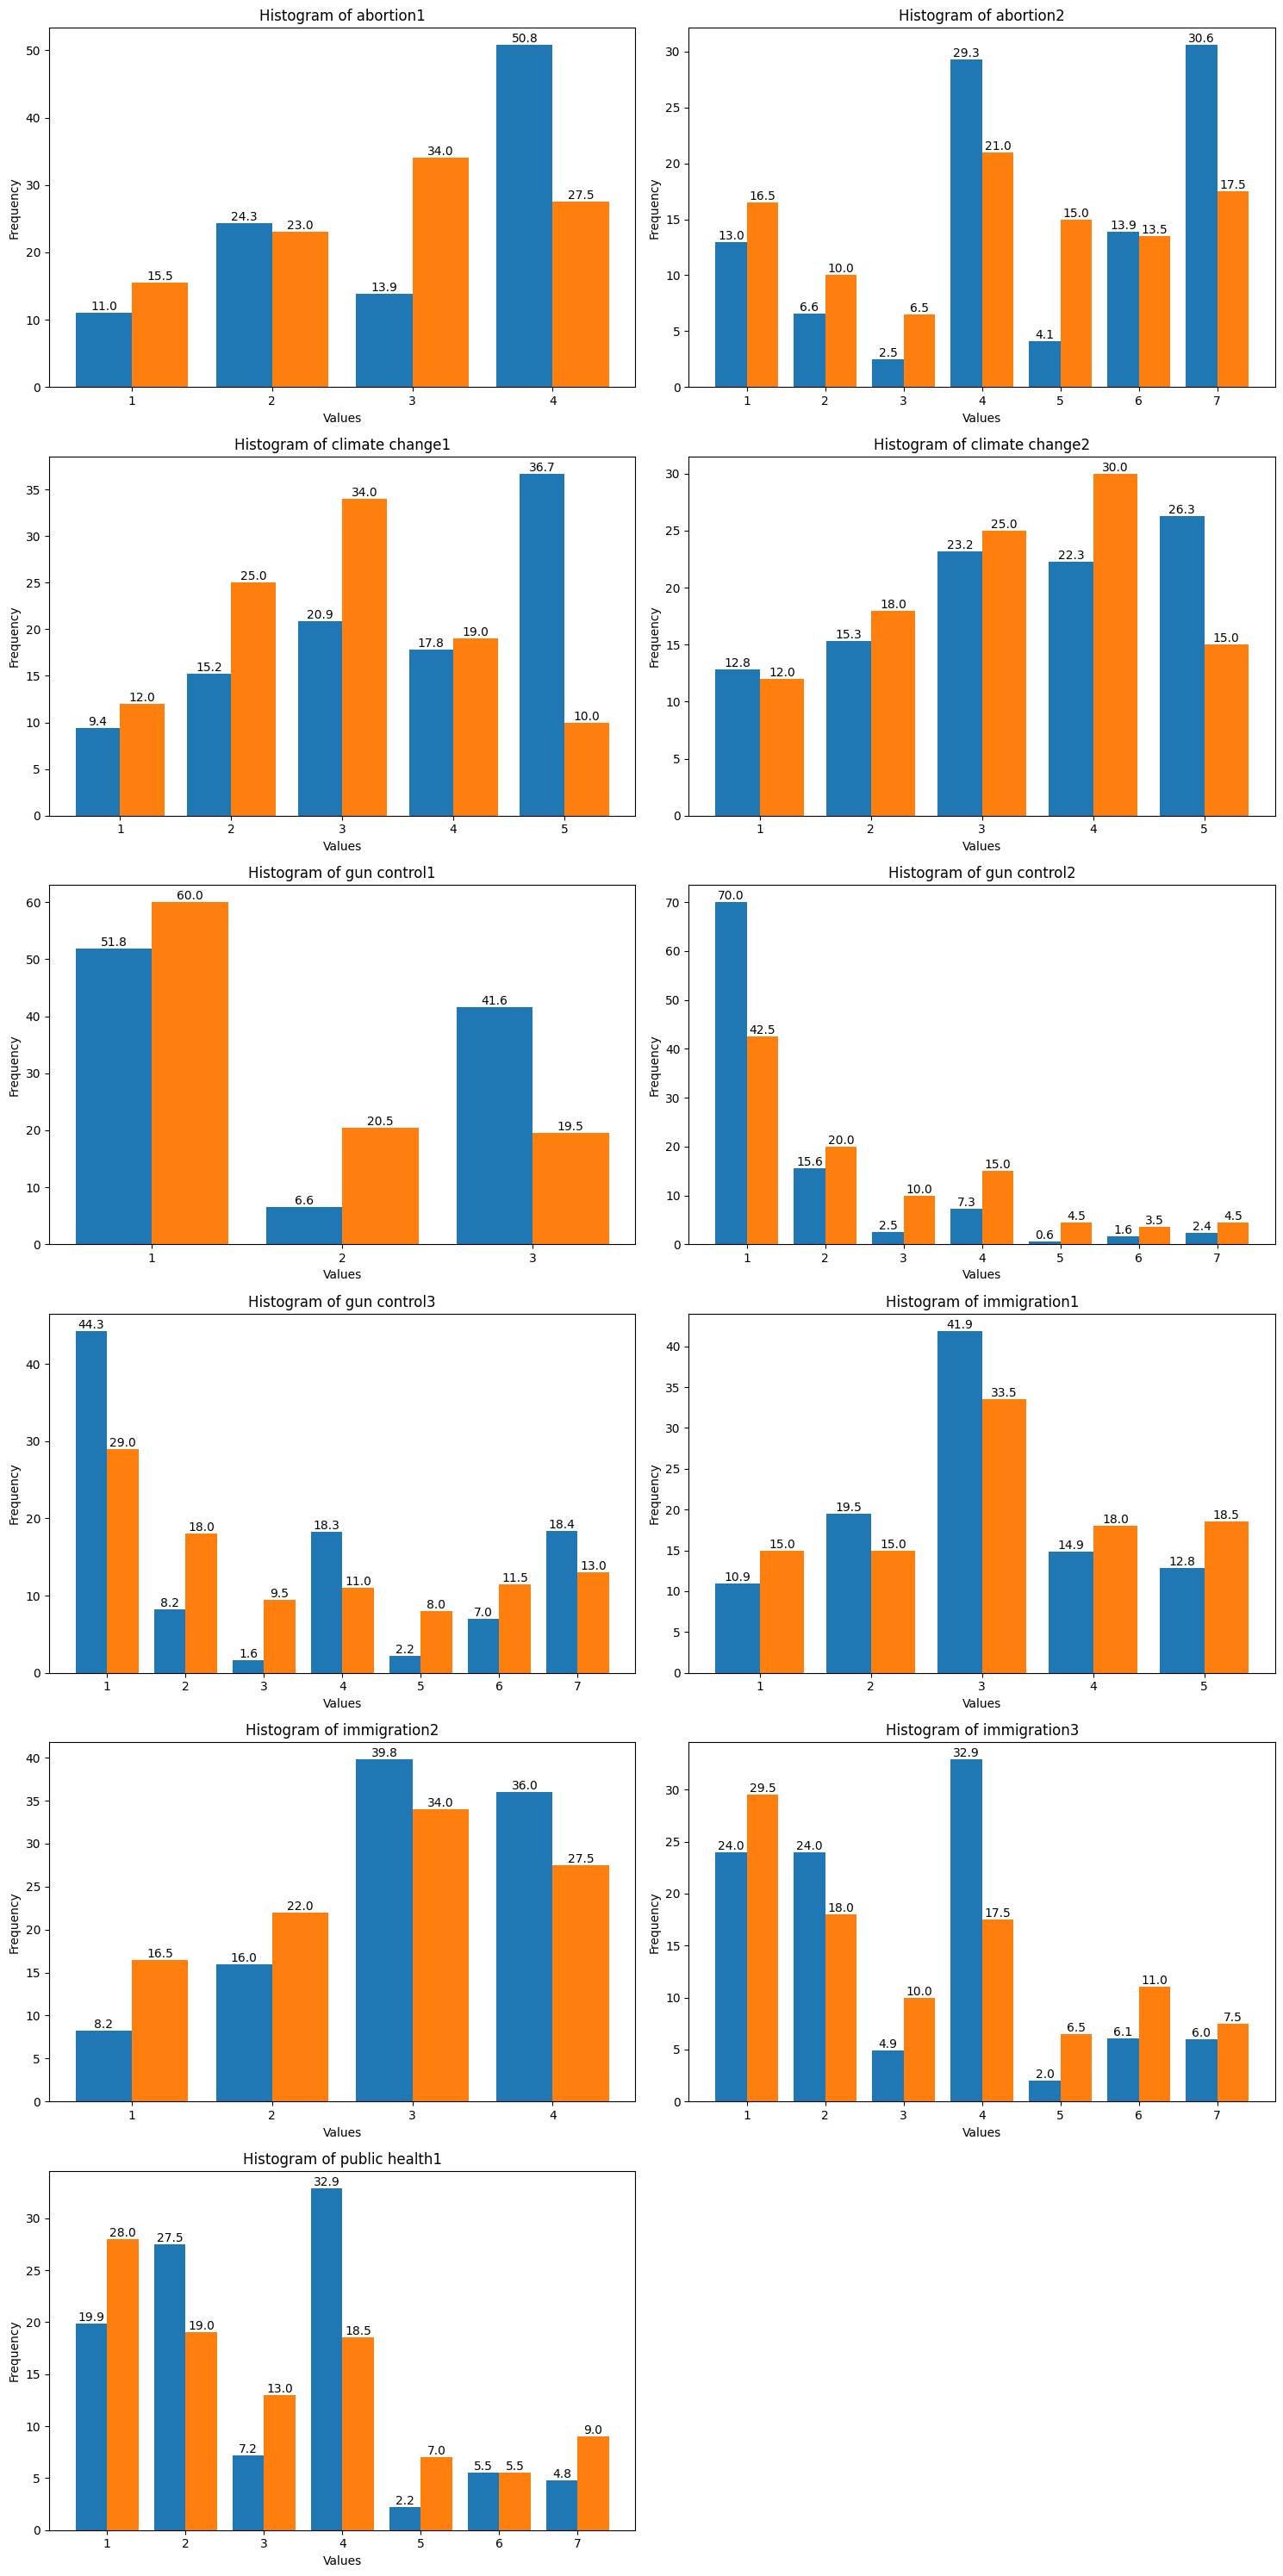

In [12]:
num_plots = len(mean_var)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)  # Round up to the nearest integer
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for idx, (key, values) in enumerate(mean_var.items()):
    try:
        valid_ans = anes[anes[key] > 0]
        issue = questcode_topic[key]

        # Calculate number of unique answers
        num_answers = len(valid_ans[key].unique())
        counts_ai = openai_results[key][3].values()

        labels, counts = np.unique(valid_ans[key].to_numpy(), return_counts=True)
        percentages = np.around((counts / np.sum(counts)) * 100, 1)
        bar_width = 0.4

        row = idx // num_cols
        col = idx % num_cols

        axs[row, col].bar(labels - bar_width/2, percentages, width=bar_width, align='center')
        axs[row, col].bar(labels + bar_width/2, counts_ai, width=bar_width, align='center')

        axs[row, col].set_xticks(labels)

        for label, count in zip(labels, percentages):
            axs[row, col].text(label - bar_width/2, count, str(count), ha='center', va='bottom')
        for label, count in zip(labels, counts_ai):
            axs[row, col].text(label + bar_width/2, count, str(count), ha='center', va='bottom')

        axs[row, col].set_title('Histogram of {}'.format(issue))
        axs[row, col].set_xlabel('Values')
        axs[row, col].set_ylabel('Frequency')

    except Exception as e:
        print(f"Error in plotting {issue}: {e}")

# Remove empty subplots
for i in range(num_plots, num_rows*num_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

GPT with comments

In [9]:
with open('comments_for_prompts.json') as f:
    reddit_comments = json.load(f)

In [10]:
reddit_comments.keys()

dict_keys(['abortion', 'climate change', 'gun control', 'healthcare', 'immigration'])

In [11]:
reddit_comments['climate change'][1:]

["Comment 0: 'This may be the hottest summer in the last hundred years, but, on the bright side, it's the coldest summer of the next one hundred years!' (score: 5310)\n",
 "Comment 1: 'LA is so hot right now' (score: 3552)\n",
 "Comment 2: 'At 7:00 PM it was still 103 here in the LA basin.  I've lived here my whole life and I've never EVER seen it stay that hot that late into the afternoon.\n\nAt least it was a dry heat.' (score: 2465)\n",
 'Comment 3: \'Also of note "highest temperature ever reliably recorded on Earth" was recorded 2 weeks ago in Death Valley California on August 16th at 130 degrees Fahrenheit (54.4 celsius).\' (score: 1762)\n',
 "Comment 4: '121° that's just insane.' (score: 1081)\n",
 "Comment 5: 'That's about 50 degree Celsius for others trying to scroll down for a conversion' (score: 779)\n",
 "Comment 6: 'It was high 90’s in Colorado, this weekend. We’re getting 30° and snow on Tuesday.' (score: 713)\n",
 'Comment 7: \'We\'ll literally roasting to death 20 years 

In [12]:
def prompt_comments(topic, dicussion, question, num_respondents, num_comments = 100):
    headline = dicussion[0][10:-1]
    comments = dicussion[1:][1:num_comments+1]
    prompt_text = 'This is discussion on %s was held on Reddit in 2020. They are comments to a news article named "%s". \
    The comments score represents the net value of upvotes and downvotes. Afterwards you will be given a question followed \
    several possible answer categories. \
    Comments: %s.   \
    Please estimate how a representative sample of %d US-Americans would have answered the following question in 2020. Provide the \
    number of respondents for each answer option in percent (output a dictionary object with answer category number as \
    key and answer frequency in percent as value. Only provide the number without the percentage sign). \
    Here are the question and categories: %s'%(topic, headline, comments, num_respondents, question)

    return prompt_text

In [ ]:
#Base yourself strictly in the comments provided.

def prompt_comments_strictly(topic, dicussion, question, num_respondents, num_comments = 100):
    headline = dicussion[0][10:-1]
    comments = dicussion[1:num_comments+1]
    prompt_text = 'This is discussion on %s was held on Reddit in 2020. They are comments to a news article named "%s". \
    The comments score represents the net value of upvotes and downvotes. Afterwards you will be given a question followed \
    several possible answer categories.\
    Comments: %s.   \
    Please estimate how a representative sample of %d US-Americans would have answered the following question in 2020.\
    Base yourself strictly in the comments provided. Output the number of respondents for each answer option in percent\
    (output a dictionary object with answer category number as key and answer frequency in percent as value.\
    Only provide the number without the percentage sign).\
    Here are the question and categories: %s'%(topic, headline, comments, num_respondents, question)

    return prompt_text

In [ ]:
runs = 2
num_comments = 100

In [ ]:
openai_ans_comments = {}

for question in questions: #"questions" object has all questions 
    
    #original survey valid answers
    valid_ans = anes[anes[question] > 0]
    survey_ans = len(valid_ans)
    topic = questcode_topic[question][:-1]

    #prompt for question (question + total answers)
    prompt_text = prompt_comments(reddit_comments[topic],
                                  questions[question], 
                                  survey_ans,
                                  num_comments = num_comments)

    #answer generation
    responses = openai.ChatCompletion.create(model="gpt-3.5-turbo-0125", 
                                            messages=[{"role": "user", "content": prompt_text}],
                                            n = runs
                                            )

    final_ans = [i['message']['content'] for i in responses['choices']]
    final_ans_dict = [eval(i) for i in final_ans]
    #also include in the final object the info on the total number of respondents
    final_ans_dict.append(survey_ans)
    openai_ans_comments[question] = final_ans_dict

In [ ]:
# filename = "openai_comments_results.json"
# with open(filename, "w") as f:
#     json.dump(openai_ans_comments, f)

In [ ]:
openai_ans_comments_strict = {}

for question in questions: #"questions" object has all questions 
    
    #original survey valid answers
    valid_ans = anes[anes[question] > 0]
    survey_ans = len(valid_ans)
    topic = questcode_topic[question][:-1]

    #prompt for question (question + total answers)
    prompt_text = prompt_comments_strictly(reddit_comments[topic],
                                  questions[question], 
                                  survey_ans,
                                  num_comments = num_comments))

    #answer generation
    responses = openai.ChatCompletion.create(model="gpt-3.5-turbo-0125", 
                                            messages=[{"role": "user", "content": prompt_text}],
                                            n = runs
                                            )

    final_ans = [i['message']['content'] for i in responses['choices']]
    final_ans_dict = [eval(i) for i in final_ans]
    #also include in the final object the info on the total number of respondents
    final_ans_dict.append(survey_ans)
    openai_ans_comments_strict[question] = final_ans_dict

In [ ]:
# filename = "openai_comments_strict_results.json"
# with open(filename, "w") as f:
#     json.dump(openai_ans_comments_strict, f)

Open session implementation

Through the visited sites on open session we saw that this is usually implemented with a loop that adds the user questions and gpt answers to a prompt that is further inserted for text generation. Therefore this implementation wouldn't be useful to allow for the incorporation of prompts longer than gpt window size (16,385 tokens for gpt-3.5-turbo-0125) in gpt.

In [ ]:
## Model for mantaining session open for the project
#prompt = prompt_text

## Split prompt into chunks of 4000 tokens
#prompt_chunks = [prompt[i:i+4000] for i in range(0, len(prompt), 4000)]

# message = {"role":"user", "content": prompt_chunks[0]}

#conversation = [{"role": "system", "content": "Just mantain the session open and answer when the answer options are given to you"}]

#for chunk in prompt_chunks[1:]:
#     conversation.append(message)
#     completion = openai.ChatCompletion.create(model="gpt-3.5-turbo-0125", messages=conversation)
#     message["content"] = chunk
#     print()
#     conversation.append(completion.choices[0].message)

In [ ]:
conversation

[{'role': 'system',
  'content': 'Just mantain the session open and answer when the answer options are given to you'},
 {'role': 'user',
  'content': ': -18)\\n\', "Comment 119: \'That’s promoting murder right there... smh\' (score: -18)\\n", "Comment 120: \'I don\'t get all the enthusiasm for killing another human being.\' (score: -19)\\n", "Comment 121: \'hooray!  more dead babies!\' (score: -19)\\n", "Comment 122: \'The most dangerous place for children is their mother\'s womb\' (score: -19)\\n", "Comment 123: \'Massmurder clinic? My favorite\' (score: -19)\\n", "Comment 124: \'I don\'t really think this is newsworthy\' (score: -19)\\n", "Comment 125: \'Oops you spelled George Soros wrong.\' (score: -20)\\n", "Comment 126: \'Guy ensures thousands of baby\'s can continue to be killed in Alabama\' (score: -22)\\n", "Comment 127: \'Gotta make sure those girls can have their cake and eat it too!\' (score: -22)\\n", "Comment 128: \'Burn it to the ground\' (score: -23)\\n", "Comment 129: 